<a href="https://colab.research.google.com/github/asmaa199/SoundClassificationModel/blob/main/TreeSoundClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Model Architecture**

In [ ]:
import os
import tensorflow as tf
import tensorflow.keras as keras

In [ ]:
!pip install tensorflow-io pydub

In [ ]:
import tensorflow_io as tfio

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio, display
from pydub import AudioSegment

In [ ]:
"""Sampling rate is 8kHZ"""
FOREST_AUDIO_PATH ='/content/drive/MyDrive/tree-cutting-audio/first_forest_audio.wav'
forest_audio = AudioSegment.from_file(FOREST_AUDIO_PATH)

In [ ]:
every_ten_sec  = 8333
original_forest_audio = list(forest_audio[0::every_ten_sec])
sliced_forest_audio = list(forest_audio[0::every_ten_sec])
forest_audio_len = len(sliced_forest_audio) - 1
print(f'Forest slices len: {forest_audio_len}')

Forest slices len: 3205


In [ ]:
forest_first_ten = sliced_forest_audio[0].get_array_of_samples()
Audio(forest_first_ten, rate=forest_audio.frame_rate)

# **Chainsaw Audio**

In [ ]:
"""Samping rate is 48kHZ"""
CHAINSAW_AUDIO_PATH  = '/content/drive/MyDrive/tree-cutting-audio/chainsaw-01.wav'
chainsaw_audio = AudioSegment.from_file(CHAINSAW_AUDIO_PATH)
chainsaw_audio = chainsaw_audio.set_frame_rate(7000)
print(f'Chainsaw audio sample rate {chainsaw_audio.frame_rate}')

Chainsaw audio sample rate 7000


# **Get indices to label as positive tree cutting sounds**

In [ ]:
mid_forest_audio_idx = forest_audio_len // 2 + 1
permutated_idx = np.random.permutation(mid_forest_audio_idx)
print(f'Ratio of positive vs negative: {permutated_idx.shape[0] / forest_audio_len}')

Ratio of positive vs negative: 0.5001560062402496


In [ ]:
forest_audio_len

3205

# **Overlay audio at selected indices**

In [ ]:
for i in permutated_idx:
  audio_slice = sliced_forest_audio[i]
  overlay = audio_slice.overlay(chainsaw_audio + 2)
  sliced_forest_audio[i] =  overlay 

In [ ]:
#Listen to audio at random positions
forest_first_ten = sliced_forest_audio[permutated_idx[2]].get_array_of_samples()
Audio(forest_first_ten, rate=forest_audio.frame_rate)

In [ ]:
forest_first_ten = original_forest_audio[permutated_idx[2]].get_array_of_samples()
Audio(forest_first_ten, rate=forest_audio.frame_rate)

# **Create a Tensorflow Dataset**

In [ ]:
from tensorflow.data import Dataset

In [ ]:
def audio_label_ds():
  audio_labels = np.zeros(forest_audio_len, )
  audio_labels[permutated_idx] = 1
  for audio_segment, y in zip(sliced_forest_audio, audio_labels):
    x = audio_segment.get_array_of_samples()
    padding_amount = 133328 - len(x)
    x = np.pad(x, (0, padding_amount), 'constant', constant_values=0)[:8334]
    yield x, y

In [ ]:
audio_ds = Dataset.from_generator(audio_label_ds, (tf.float32, tf.float32))
audio_ds = audio_ds.shuffle(buffer_size=forest_audio_len)

# **Visualize DS**

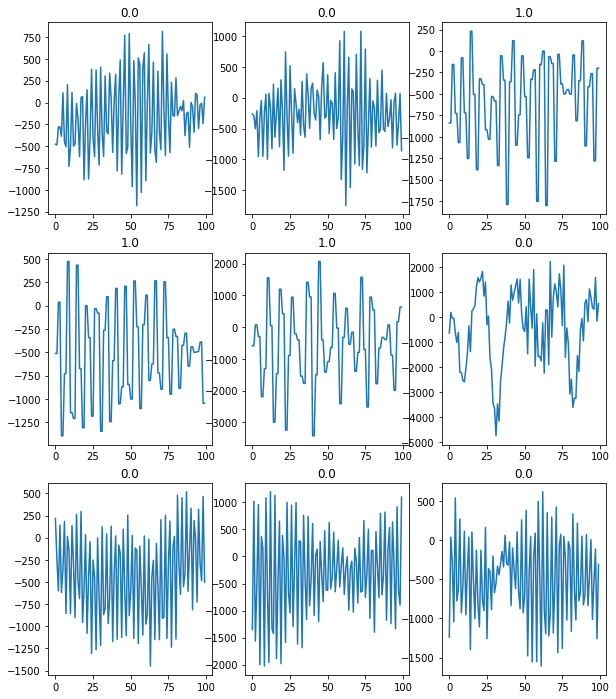

In [ ]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(audio_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy()[100:200])
  label = label.numpy()
  ax.set_title(label)

plt.show()

In [ ]:
def get_spectrogram(waveform):
  spectrogram = tf.signal.stft(waveform, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [ ]:
for waveform, label in audio_ds.take(1):
  label = label.numpy()
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)

Label: 0.0
Waveform shape: (8334,)
Spectrogram shape: (64, 129, 1)


In [ ]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

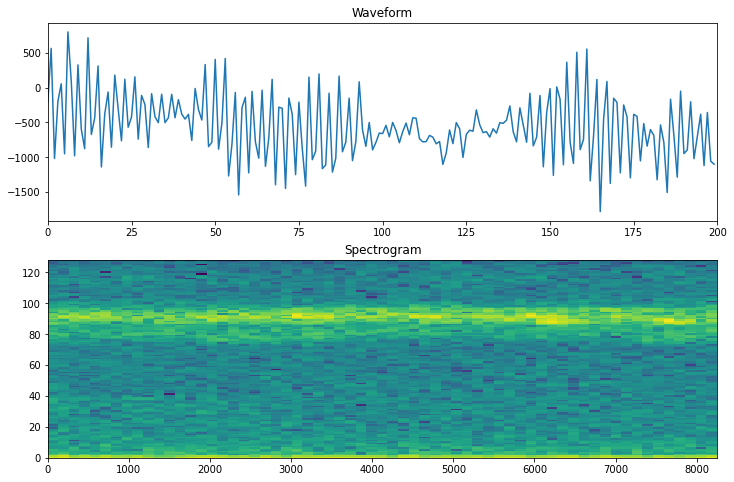

In [ ]:
for waveform, label in audio_ds.take(1):
  label = label.numpy()
  spectrogram = get_spectrogram(waveform)
  fig, axes = plt.subplots(2, figsize=(12, 8))
  timescale = np.arange(200)
  axes[0].plot(timescale, waveform.numpy()[:200])
  axes[0].set_title('Waveform')
  axes[0].set_xlim([0, 200])

  plot_spectrogram(spectrogram.numpy()[:200], axes[1])
  axes[1].set_title('Spectrogram')
  plt.show()

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  return spectrogram, label

In [ ]:
spectrogram_ds = audio_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=tf.data.AUTOTUNE)

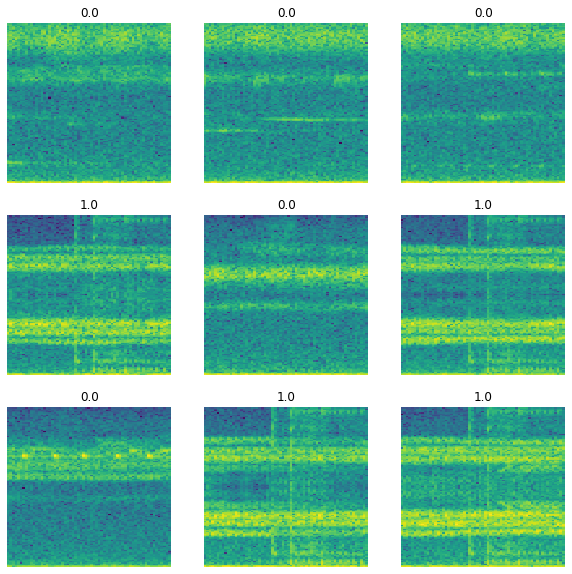

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy()[:200], ax)
  ax.set_title(label_id.numpy())
  ax.axis('off')

plt.show()

# **Listen to audio**

In [ ]:
for i, (audio, label_id) in enumerate(audio_ds.take(9)):
  display(Audio(audio.numpy(), rate=forest_audio.frame_rate))
  print(label_id.numpy())

1.0


0.0


0.0


1.0


1.0


0.0


0.0


0.0


0.0


In [ ]:
print(f'Dataset len {forest_audio_len}')

BATCH_SIZE = 64

train_size = int(0.8 * forest_audio_len)
val_test_size = int(forest_audio_len * 0.1)

train_ds = spectrogram_ds.take(train_size).shuffle(train_size).batch(BATCH_SIZE)
val_ds = spectrogram_ds.skip(train_size).take(val_test_size).shuffle(val_test_size).batch(BATCH_SIZE)
eval_test_ds = spectrogram_ds.skip(train_size + val_test_size).take(val_test_size)
test_ds = eval_test_ds.shuffle(val_test_size).batch(BATCH_SIZE)

Dataset len 3205


# **ResNet**

In [ ]:
class residual_block(keras.layers.Layer):
  def __init__(self, channels, identity_block=None, stride=1):
    super(residual_block, self).__init__()

    self.identity_block = identity_block
    self.conv1 = keras.layers.Conv2D(channels, kernel_size=1, strides=stride, padding='valid')
    self.relu = keras.layers.ReLU()
    self.bn1 = keras.layers.BatchNormalization()
    self.conv2 = keras.layers.Conv2D(channels, kernel_size=3, strides=1, padding='same')
    self.bn2 = keras.layers.BatchNormalization()
    self.conv3 = keras.layers.Conv2D(channels * 4, kernel_size=1, strides=1, padding='valid')
    self.bn3 = keras.layers.BatchNormalization()
    self.add = keras.layers.Add()
  
  def call(self, x):
    y = tf.identity(x)
    x = self.conv1(x)
    x = self.bn1(x)
    x = self.relu(x)

    x = self.conv2(x)
    x = self.bn2(x)
    x = self.relu(x)

    x = self.conv3(x)
    x = self.bn3(x)
    
    if self.identity_block is not None:
      y = self.identity_block(y)
    
    x = self.add([x, y])
    
    return self.relu(x) 
    

In [ ]:
class ResNet(keras.Model):
  def __init__(self, classes=3, layers = [3, 6, 4, 3]):
    super(ResNet, self).__init__()
    self.classes = classes
    self.res_layers = layers
    self.intermediate_channels = 64

    #Preprocessing layers
    self.resize = keras.layers.Resizing(224, 224)
    self.rescale = keras.layers.Rescaling(1.0 / 255)

    self.padding = keras.layers.ZeroPadding2D((3, 3))
    self.conv1 = keras.layers.Conv2D(self.intermediate_channels, kernel_size=7, strides=(2, 2) )
    self.bn1 = keras.layers.BatchNormalization()
    self.relu = keras.layers.ReLU()
    self.max_pool = keras.layers.MaxPool2D((3, 3), strides=(2, 2))
    self.residual_blocks = []
    
    for layer_idx in range(len(layers)):
      
      channels = self.intermediate_channels
      stride = 1 if layer_idx < 1 else 2
      identity_block = None

      identity_block = keras.Sequential(
            [ keras.layers.Conv2D(channels * 4, kernel_size=1, strides=stride, padding='valid'), 
             keras.layers.BatchNormalization()])
        
      self.residual_blocks.append(
          residual_block(
              channels, identity_block, stride
              )
          )
      
      for block in range(self.res_layers[layer_idx] - 1):
        self.residual_blocks.append(
            residual_block(self.intermediate_channels)
        )

      self.intermediate_channels = self.intermediate_channels * 2

    self.average_pool = keras.layers.AveragePooling2D((2, 2))
    self.flatten = keras.layers.Flatten()
    self.dense = keras.layers.Dense(classes)
    self.activation = keras.layers.Activation('sigmoid')
  
  def call(self, x):
    x = self.resize(x)
    x = self.rescale(x)
    x = self.padding(x)
    x = self.relu(self.bn1(self.conv1(x)))
    x = self.max_pool(x)
    for i, block in enumerate(self.residual_blocks):
      x = block(x)
    
    x = self.average_pool(x)
    x = self.flatten(x)
    x = self.dense(x)
    
    return self.activation(x)

**ResNet Test**

In [ ]:
x =tf.random.uniform([2, 224, 224, 3])
model = ResNet()
output = model(x)
output.shape

TensorShape([2, 3])

In [ ]:
model.summary()

Model: "res_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         multiple                  0         
                                                                 
 rescaling (Rescaling)       multiple                  0         
                                                                 
 zero_padding2d (ZeroPadding  multiple                 0         
 2D)                                                             
                                                                 
 conv2d (Conv2D)             multiple                  9472      
                                                                 
 batch_normalization (BatchN  multiple                 256       
 ormalization)                                                   
                                                                 
 re_lu (ReLU)                multiple                  0   

In [ ]:
from collections import OrderedDict

In [ ]:
class FeaturePyramidNetwork(keras.layers.Layer):
  def __init__(self, num_layers=3, out_channels=256):
    super(FeaturePyramidNetwork, self).__init__()

    self.lateral_layers = []
    self.output_layers = []
    
    for _ in range(num_layers):
      self.lateral_layers.append(keras.layers.Conv2D(out_channels, kernel_size=3, padding='same'))
      self.output_layers.append(keras.layers.Conv2D(out_channels, kernel_size=1, padding='same'))
    
    self.interp_layer = keras.layers.UpSampling2D((2, 2))
  
  def call(self, x):
    names = list(x.keys())
    outputs = list(x.values())
    network_outputs = []
  
    last_lateral_output = self.lateral_layers[-1](outputs[-1])
    network_outputs.append(self.output_layers[-1](last_lateral_output))
  
    for idx in range(len(outputs) - 2, -1, -1):
      lateral_output = self.lateral_layers[idx](outputs[idx])
      previous_interpolation = self.interp_layer(last_lateral_output)
      last_lateral_output = lateral_output + previous_interpolation
      network_outputs.append(self.output_layers[idx](last_lateral_output))
  
    output = OrderedDict([(k, v) for k, v in zip(names, network_outputs)])
  
    return output

**FPN test**

In [ ]:
x_dict = OrderedDict()
x_dict['f1'] = tf.random.uniform([1, 112, 112, 64])
x_dict['f2'] = tf.random.uniform([1, 56, 56, 128])
x_dict['f3'] = tf.random.uniform([1, 28, 28, 256])
output = FeaturePyramidNetwork()(x_dict)
print([(k, v.shape) for k, v in output.items()])

[('f1', TensorShape([1, 28, 28, 256])), ('f2', TensorShape([1, 56, 56, 256])), ('f3', TensorShape([1, 112, 112, 256]))]


# **Train, Val, Test**

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
#Create checkpoint dir if it does not exist
CHECKPOINT_PATH = '/content/tree_sound_ckpt'
if not os.path.exists(CHECKPOINT_PATH):
  os.makedirs(CHECKPOINT_PATH)

In [ ]:
model = ResNet(classes=1)

#Callbacks
early_stopping = EarlyStopping(monitor='val_accuracy', mode='max', patience=3)
model_checkpoint = ModelCheckpoint(CHECKPOINT_PATH, monitor='val_accuracy', mode='max', save_best_only=True)

#Compile Model
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(from_logits=False), metrics=['accuracy'], run_eagerly=True )

In [ ]:
EPOCHS = 2
BATCH_SIZE = 64

model_history = model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS, callbacks=[early_stopping, model_checkpoint])

Epoch 1/2
     41/Unknown - 69s 1s/step - loss: 0.5664 - accuracy: 0.9661

INFO:tensorflow:Assets written to: /content/tree_sound_ckpt/assets


INFO:tensorflow:Assets written to: /content/tree_sound_ckpt/assets


41/41 [==============================] - 104s 2s/step - loss: 0.5664 - accuracy: 0.9661 - val_loss: 17.3889 - val_accuracy: 0.7375


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


Epoch 2/2
41/41 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 0.9996

INFO:tensorflow:Assets written to: /content/tree_sound_ckpt/assets


INFO:tensorflow:Assets written to: /content/tree_sound_ckpt/assets


41/41 [==============================] - 100s 2s/step - loss: 0.0015 - accuracy: 0.9996 - val_loss: 0.4477 - val_accuracy: 0.9156


/usr/local/lib/python3.7/dist-packages/keras/saving/saved_model/layer_serialization.py:112: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  return generic_utils.serialize_keras_object(obj)


In [ ]:
evaluation_model = model.evaluate(test_ds, return_dict=True)

5/5 [==============================] - 7s 401ms/step - loss: 0.4145 - accuracy: 0.9156


In [ ]:
print(f'Eval loss: {evaluation_model["loss"]}')
print(f'Eval accuracy {evaluation_model["accuracy"]}')

Eval loss: 0.4144879877567291
Eval accuracy 0.9156249761581421


# **Prediction on pure forest sound**

In [ ]:
f10_forest_tensor = tf.constant(forest_first_ten, dtype=tf.float32)
f10_forest_spectrogram = get_spectrogram(f10_forest_tensor)
preds = model.predict(tf.expand_dims(f10_forest_spectrogram, axis=0))
assert preds[0] < 0.5

# **Prediction on chainsaw audio only**

In [ ]:
chainsaw_tensor = tf.constant(chainsaw_audio.get_array_of_samples(), dtype=tf.float32)
chainsaw_spectrogram = get_spectrogram(chainsaw_tensor)
preds = model.predict(tf.expand_dims(chainsaw_spectrogram, axis=0))
#assert preds[0] > 0.5

# **Prediction on test ds**

In [ ]:
preds = model.predict(eval_test_ds.batch(BATCH_SIZE))
_, labels = tuple(zip(*eval_test_ds))
labels = np.array(labels)

In [ ]:
preds = np.array(preds)
preds = np.squeeze(preds, axis=-1)
preds = (preds > 0.5).astype(int)

In [ ]:
!zip -r /content/tree_sound_ckpt.zip /content/tree_sound_ckpt

  adding: content/tree_sound_ckpt/ (stored 0%)
  adding: content/tree_sound_ckpt/keras_metadata.pb (deflated 95%)
  adding: content/tree_sound_ckpt/assets/ (stored 0%)
  adding: content/tree_sound_ckpt/saved_model.pb (deflated 92%)
  adding: content/tree_sound_ckpt/variables/ (stored 0%)
  adding: content/tree_sound_ckpt/variables/variables.index (deflated 80%)
  adding: content/tree_sound_ckpt/variables/variables.data-00000-of-00001 (deflated 8%)
